## Wstęp

Dzisiaj zapoznasz się z jednym z najważniejszych zagadnień w kryptografii - czyli z funkcjami skrótu. Opowiemy sobie czym one są, do czego służą i gdzie są wykorzystywane na przykładzie standardu SHA-3.

## Funkcje skrótu

Zwane też: funkcje skracające, funkcje mieszające, funkcje haszujące, a z języka ang. *hashing functions*. W słowniku języka polskiego nie ma oficjalnej nazwy tych funkcji, dlatego podałem wszystkie z którymi możesz się spotkać w literaturze.

Z natury są to funkcje jednokierunkowe, które jako wejście przyjmują ciąg binarny o potencjalnie nieograniczonej długości, a jako wyjście zwracają ciąg binarny zawsze tej samej długości:
$$
h: \{0, 1\}^* \rightarrow  \{0, 1\}^n
$$
gdzie *h* oznacza funkcję skrótu, a *n* to długość zwracanego skrótu. Ta matematyczna definicja nie uwzględnia jednak pewnych dodatkowych właściowści, które funkcja skótu powinna posiadać. Są to:
- skrót powinien być łatwy do obliczenia (wydajność),
- dysponując funkcją skrótu *h* oraz skrótem oznaczonym jako *h(x)* powinno być niewykonalne (a przynajmniej bardzo, bardzo trudne) znalezienie wartości *x*. Ta własność jest określana jako bezpieczeństwo pierwszego preobrazu (z ang. *first preimage resistance*),
- mając **podane** *h* oraz *x*, powinno być bardzo trudne odnalezienie wartości *y* takiej, że *h(x) = h(y)*. Ta własność jest określana jako bezpieczeństwo drugiego preobrazu (z ang. *second preimage resistance*),
- powinno być także trudno znaleźć dwie **dowolne** wartości *x* oraz *y* takie, że *h(x) = h(y)*. Ta własność zwana jest odpornością na kolizje (z ang. *collision resistance*).

Bezpieczeństwo funkcji skrótu podajemy w tzw. bitach bezpieczeństwa. Jeżeli funkcja skrótu posiada *b* bitów bezpieczeństwa odporności na dany atak, to znaczy, że atakujący musałby wykonać $2^b$ operacji aby atak się udał. Teoretyczne maksymalne wartości liczby bitów bezpieczeństwa to $n$ w przypadku ataków na pierwszy i drugi preobraz, oraz $\frac{n}{2}$ w przypadku szukaniu kolizji (ta wartość wynika z [paradoksu urodzin](https://en.wikipedia.org/wiki/Birthday_problem)), gdzie tak jak poprzednio *n* oznacza długość zwracanego skrótu. Mówiąc o bezpieczeństwie trzeba jednak pamiętać o jednym. Każda funkcja skrótu jest do złamania. Wynika to z prostego faktu: posiadamy teoretycznie nieograniczoną liczbę wejść, a ograniczoną (choć za zwyczaj jest to wartość duża) liczbę wyjść.

No dobrze, tylko gdzie my możemy funkcje skrótu wykorzystać? Obecnie wyszczególniłbym następujące schematy wykorzystujące funkcje skrótu:
- przechowywanie haseł w bazie danych,
- weryfikacja integralności danych (w szczególności schematy podpisu cyfrowego),
- kryptografia post-quantum, w szczególności gałąź zwana *hash-based cryptography*, o której więcej możesz przeczytać [tutaj](https://en.wikipedia.org/wiki/Hash-based_cryptography).

W historii były cztery światowe standardy: SHA-0, SHA-1, SHA-2 i SHA-3, gdzie skrót *SHA* oznacza z ang. *Secure Hash Algorithm*. Standaryzacją zajmuje się organizacja NIST (*National Institute of Standards and Technology*) ulokowana w USA. Mało popularny SHA-0 oraz znacznie popularniejszy SHA-1 są **niezalecane do użycia**. Zostały złamane. SHA-2 i SHA-3 to już nie pojedyncze funkcje skrótu, ale raczej ich rodziny. Oznaczenie SHA-256 mówi nam o funkcji skrótu z rodziny SHA-2 zwracającej 256 bitowy skrót. Analogicznie SHA3-256. Najbardziej popularne długości skrótu (choć oczywiście nie jedyne) to 256 i 512 bitów. Standardy SHA które nie zostały złamane i zaleca się je do użycia określamy mianem SHS (z ang. *Secure Hash Standard*).

## SHA-3

Po serii udanych ataków na funkcję SHA-1, które miały miejsce w 2004 i 2005 roku, świat został z w zasadzie jednym standardem, SHA-2. NIST i specjaliści z całego świata byli zgodni, że to ryzykowane nie mieć żadnej bezpiecznej alternatywy - stąd w 2007 roku ogłoszono konkurs na SHA-3. Konkurs miał 3 rundy i trwał dość długo, bo wpłynęły aż 64 zgłoszenia. Ostatecznie w 2012 roku ogłoszono, że zwycięzcą został algorytm Keccaka i to on stał się nowym standardem, SHA-3. Dzisiaj go zaprogramujemy.

Czy SHA-3 jest trudny do zaprogramowania? Powiem tak. Moim zdaniem, korzystając tylko z dokumentacji twórców trochę tak, bo jest kilka małych pułapek. Dlatego opiszę Ci krok po kroku co powinno się zrobić i będzie nieco łatwiej.

Dla zainteresowanych przydatne linki: [strona twórców](https://keccak.team/keccak_specs_summary.html), [NIST FIPS PUB 202](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.202.pdf) i ostatnia, **ważna** która przyda nam się na końcu ćwiczeń: [debug data](https://csrc.nist.gov/Projects/cryptographic-standards-and-guidelines/example-values) - interesuje nas wiersz SHA3-512 z tabeli.



### Krok 1 - stałe

SHA-3 jest bardzo wszechstronny, pozwala dopasować wersję algorytmu do długości słowa bitowego obsługiwanego przez nasz procesor. Dla najbardziej popularnej długości obecnie, czyli 64 bity, stosuje się wersję algorytmu zwaną Keccak-1600. Można stosować inne, opisane w NIST FIPS PUB 202, ale my kierujemy się wydajnością. 1600 oznacza, że w każdej rundzie algorytmu będziemy operować na 1600 bitach danych, a więc 200 bajtach. Ta liczba oczywiście jest nieprzypadkowa. Zauważ, że 200 bajtów, to dokładnie 25 słów bitowych, każde po 64 bity. Te 25 słów bitowych formowane jest w dwuwymiarową tablicę 5x5. Ta tablica zwana jest przez twórców *State*.

No dobrze, ale jak się do tego ma wiadomość? Tutaj z pomocą przychodzą dwie stałe: $r$ oraz $c$ opisane [tu](https://keccak.team/keccak.html). Stała $r$ oznacza *bit rate*, $c$ *capacity*, a ich wartości zależą od tego, jaką wersję algorytmu SHA-3 zastosujemy (my skupimy się na SHA3-512). SHA-3 działa na zasadzie funkcji gąbki, to znaczy w pętli głównej wchłaniana jest odpowiednia liczba bitów wiadomości do tablicy state, wykonujemy odpowiednie obliczenia, wchłaniamy kolejną porcję, liczymy itd. W naszym przypadku $r = 576$ bitów, a więc 72 bajty. $c$ to po prostu uzupełnienie, zauważ, że wchłaniana liczba bitów jest mniejsza niż rozmiar State, stąd dla $c = 1024$, $r + c = 1600$.

$n$ oznacza liczbę rund. Po wchłonięciu porcji danych $n$ razy wykonujemy zestaw funkcji opisanych przez twórców (o których później), gdzie $n = 12 + 2l$. Z tabeli 1 w dokumentacji NIST można wyczytać, że dla wersji Keccak-1600, $l = 6$, a więc nasza liczba rund to $n = 24$.

$RC$ to tablica 24 stałych, po jednej dla każdej z 24 rund, natomiast $rotations$ to tablica wartości, która mówi nam o ile mamy rotować słowo bitowe. Jest ona potrzebna w jednej funkcji z zestawu przedstawionego przez twórców.

Zadeklarujmy nasze stałe. Dla wygody wartości $r$ oraz $c$ zadeklarujemy jako liczbę bajtów.

In [16]:
n = 24
r = 576 // 8
c = 1024 // 8

RC = [0x0000000000000001,
      0x0000000000008082,
      0x800000000000808A,
      0x8000000080008000,
      0x000000000000808B,
      0x0000000080000001,
      0x8000000080008081,
      0x8000000000008009,
      0x000000000000008A,
      0x0000000000000088,
      0x0000000080008009,
      0x000000008000000A,
      0x000000008000808B,
      0x800000000000008B,
      0x8000000000008089,
      0x8000000000008003,
      0x8000000000008002,
      0x8000000000000080,
      0x000000000000800A,
      0x800000008000000A,
      0x8000000080008081,
      0x8000000000008080,
      0x0000000080000001,
      0x8000000080008008]

rotations = [[0, 36, 3, 41, 18], [1, 44, 10, 45, 2], [62, 6, 43, 15, 61], [28, 55, 25, 21, 56], [27, 20, 39, 8, 14]]

### Krok 2 - Padding

Zauważ, że w każdej głównej iteracji algorytmu wchłaniamy 72 bajty wiadomości (wartość $r$). Jest bardzo mało prawdopodobne, że nasza wiadomość będzie akurat miała długość w bajtach równą 72 lub wielokrotności 72. Tutaj z pomocą przychodzi *padding*, czyli uzupełnianie wiadomości do wymaganej długości. Wskazówka: jako *wiadomość* rozum ciąg bajtów, czyli *bytearray* z którym będziemy robić sporo rzeczy.

SHA-3 stosuje metodę pad10*110, czyli w zamyśle dołącz do wiadomości bit 1, następnie odpowiednią liczbę bitów 0 i zamknij ciąg bitem 1. W SHA-3 ten algorytm jest wzbogacony o stałą 0x06:

1) Oblicz q = r - (len(msg) mod r). Zauważ, że $r$ i $len(m)$ zwracają długości w bajtach.

2) Jeżeli q = 1 wykonaj: dołącz do wiadomości bajt 0x86.

3) Jeżeli q = 2 wykonaj: dołącz do wiadomości bajt 0x06, a następnie dołącz do wiadomości bajt 0x80.

4) Jeżeli q > 2 wykonaj: dołącz do wiadomości bajt 0x06, następnie dołącz do wiadomości dokładnie $q - 2$ bajty 0x00 i na końcu dołącz do wiadomości bajt 0x80.

Sprawdź reprezentację bitową 0x80 oraz 0x86, jak wspominałem stała 0x06 to już dodatek autorów. Czy widzisz w powyższym algorytmie coś dziwnego? Jakiego porządku bitów używa SHA-3? W każdym przypadku, po operacji paddingu len(msg) powinno być wielokrotnością 72.

**Zadanie 1**

Napisz ciało metody pad10*110. Parametrem metody jest tablica bajtów wiadomości (bytearray).

In [17]:
def pad(msg):
    q = r - (len(msg) % r)
    if q == 1:
        return msg + bytes([0x86])
    if q == 2:
        return msg + bytes([0x06, 0x80])
    return msg + bytes([0x06] + [0] * (q - 2) + [0x80])

### Krok 3 - funkcje pomocnicze

Będziemy potrzebowali operować na wartości State na dwa sposoby: raz jako na tablicy bajtów o długości 200 (potrzebne przy wchłanianiu danych), a raz jako na dwuwymiarowej tablicy 64-bitowych słów o rozmiarach 5x5 (potrzebne w dalszej części). Musimy napisać łącznie trzy funkcje pomocnicze:

1) convertToInts(state) - ta funkcja powinna pobierać State w formie wektora bajtów i zwracać tablicę 5x5. Algorytm jest taki, że licząc od początku pobieramy po 8 bajtów (64 bity) i przypisujemy do nowego State'a (oznaczmy go jako State'), ale uwaga, dane układamy wierszami. A więc bajty 0-7 wektora State konwertujemy na liczbę i przypisujemy do State'[0][0], bajty 8-15 ze State przypisujemy jako liczbę do State'[1][0] itd. Dodatkowo, konwertując bajty na liczby używamy porządku **Little Endian**.

2) convertToBytes(state) - ta funkcja pobiera State jako dwuwymiarową tablicę i konwertuje z poworotem na wektor bajtów State' (nowy State). Dane również pobieramy wierszami i dekodujemy w porządku **Little Endian**. A więc liczba przechowywana w State[0][0] jest kodowana jako 8 pierwszych bajtów State', liczba w State[1][0] jako 8 kolejnych bajtów itd. Czyli robimy funkcję odwrotną do poprzedniej. Funkcja zwraca State' o rozmiarze 1600 bitów.

3) rot(a, b) - ta funkcja dokonuje bitowej rotacji 64 bitowej liczby $a$ w lewo o $b$ bitów.

**Zadanie 2**

Uzupełnij ciała metod convertToBytes oraz convertToInts zgodnie z powyższym opisem.

In [18]:
def convertToInts(state):
    result = [[0 for _ in range(5)] for _ in range(5)]
    for y in range(5):
        for x in range(5):
            start = 8 * (x + 5 * y)
            value = int.from_bytes(state[start:start + 8], 'little')
            result[x][y] = value & 0xFFFFFFFFFFFFFFFF
    return result

def convertToBytes(state):
    result = bytearray()
    for y in range(5):
        for x in range(5):
            value = state[x][y] & 0xFFFFFFFFFFFFFFFF
            result.extend(value.to_bytes(8, 'little'))
    return result

def rot(a, b):
    a = a & 0xFFFFFFFFFFFFFFFF
    return ((a << b) | (a >> (64 - b))) & 0xFFFFFFFFFFFFFFFF

### Krok 4 - permutacje

SHA-3 wykorzystuje zestaw pięciu permutacji, które wykorzystywane są w każdej pojedynczej rundzie (*rundzie*, nie iteracji pętli głównej algorytmu). Nie są one skomplikowane, dlatego nie będziemy pisali oddzielnej funkcji do każdej z nich. Każda z nich korzysta ze State'a jako tablicy liczby 5x5.
**NOTE: indeksy liczymy modulo 5.**

1) Krok $Θ$ wykonaj:
- C[i] = state[i][0] xor state[i][1] xor state[i][2] xor state[i][3] xor state[i][4] dla i = 0,...,4. C to wektor pomocniczy.
- D[i] = C[i-1] xor rot(C[i+1], 1) dla i = 0,...,4, D to wektor pomocniczy.
- state[i][j] = state[i][j] xor D[i], dla i,j = 0,...,4.

2) Kroki $ρ$ oraz $π$ wykonaj: B[j][2 * i + 3 * j] = rot(state[i][j], rotations[i][j]), B to zmienna pomocnicza.

3) Krok $Χ$ wykonaj: state[i][j] = B[i][j] xor ((~B[i + 1][j]) & B[i + 2][j]).

4) Krok $ι$ wykonaj: state[0][0] = state[0][0] xor RC. RC to stała, którą będziemy przekazywać do funkcji realizującej te permutacje.

Ostatecznie mamy do napisania dwie funkcje w pythonie: *compute* i *oneRound*.

Funkcja *compute(state)* przyjmuje jako parametr State w formie wektora bajtów i wykonuje następujące czynności:

1) Przekonwertuj State do formy tablicy liczb.

2) Wykonuj *state = oneRound(state, RC[i])* dla i = 0,...,n-1

3) Przekonwertuj State do wektora bajtów.

4) Zwróc State.

Funkcja *oneRound(state, RC)* wykonuje obliczenia dla pojedynczej rundy:

1) Utwórz niezbędne zmienne pomocnicze.

2) Wykonaj krok $Θ$.

3) Wykonaj kroki $ρ$ oraz $π$.

4) Wykonaj krok $Χ$.

5) Wykonaj krok $ι$.

6) Zwróć State.

**Zadanie 3**

Uzupełnij ciała metod *compute* i *oneRound* zgodnie z algorytmem opisanym powyżej.

In [19]:
def compute(state):
    state = convertToInts(state)
    for i in range(n):
        state = oneRound(state, RC[i])
    return convertToBytes(state)

def theta(state):
    C = [0] * 5
    for x in range(5):
        C[x] = state[x][0] ^ state[x][1] ^ state[x][2] ^ state[x][3] ^ state[x][4]
    
    D = [0] * 5
    for x in range(5):
        D[x] = C[(x-1) % 5] ^ rot(C[(x+1) % 5], 1)
    
    new_state = [[0 for _ in range(5)] for _ in range(5)]
    for y in range(5):
        for x in range(5):
            new_state[x][y] = state[x][y] ^ D[x]
    
    return new_state

def rho_pi(state):
    new_state = [[0 for _ in range(5)] for _ in range(5)]
    for y in range(5):
        for x in range(5):
            new_state[y][(2*x + 3*y) % 5] = rot(state[x][y], rotations[x][y])
    return new_state

def chi(state):
    new_state = [[0 for _ in range(5)] for _ in range(5)]
    for y in range(5):
        for x in range(5):
            new_state[x][y] = state[x][y] ^ ((~state[(x+1) % 5][y]) & state[(x+2) % 5][y])
    return new_state

def iota(state, rc):
    new_state = [row[:] for row in state]
    new_state[0][0] ^= rc
    return new_state

def oneRound(state, rc):
    state = theta(state)
    state = rho_pi(state)
    state = chi(state)
    state = iota(state, rc)
    return state

### Krok 5 - główna pętla algorytmu

Wreszcie możemy napisać funkcję główną liczącą skrót *sha3-512*. Przyjmuje ona jako parametr bajty wiadomości $m$ i zwraca bajty skrótu:

1) Dokonaj paddingu wiadomości.

2) Wchłoń $r$ bajtów wiadomości do State'a. "Wchłanianie" oznacza tu operację XOR kolejnych bajtów wiadomości z $r$ początkowymi bajtami State'a.

3) Wywołaj metodę *compute(state)*.

4) Powtarzaj kroki 2 i 3 dopóki cała wiadomość nie zostanie wchłonięta.

5) Zwróć pierwsze 64 bajty State'a. To jest nasz 512-bitowy skrót.

**Zadanie 4**

Uzupełnij kod poniższej metody tak, aby zwracała skrót z wiadomości. Przetestuj tę metodę, czy działa prawidłowo. Tablicę bajtów przez nią zwróconą trzeba przekonwertować na ciąg znaków hexadecymalnych i wypisać na ekranie. Przetestuj funkcję dla poniższych ciągów znakowych:

1) ""

2) "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"

3) "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"

Porównaj, czy skróty zgadzają się ze zwróconymi z [tego](https://www.browserling.com/tools/sha3-hash) kalkulatora lub zaimportuj bibliotekę hashlib i porównaj swoje wyniki z jej wynikami.

In [20]:
def sha3_512(m):
    if isinstance(m, str):
        m = m.encode()
    
    m = pad(m)
    state = bytearray([0] * 200)
    
    for i in range(0, len(m), r):
        block = bytearray(m[i:i+r])
        for j in range(len(block)):
            state[j] ^= block[j]
        
        state = compute(state)
    
    return bytes(state[:64])

In [21]:
# Test vectors
test_strings = [
    "",
    "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa",
    "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"
]

for test_str in test_strings:
    hash_value = sha3_512(test_str)
    print(f"Input: {test_str}")
    print(f"Hash: {hash_value.hex()}")
    print()

Input: 
Hash: a69f73cca23a9ac5c8b567dc185a756e97c982164fe25859e0d1dcc1475c80a615b2123af1f5f94c11e3e9402c3ac558f500199d95b6d3e301758586281dcd26

Input: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Hash: a8ae722a78e10cbbc413886c02eb5b369a03f6560084aff566bd597bb7ad8c1ccd86e81296852359bf2faddb5153c0a7445722987875e74287adac21adebe952

Input: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Hash: 208c7a62579fc826dd6be329089bba5e782f01a2ca3d9890a583042560164e97eda638108d69cc965aa8c6c073256717d9c4985921f43544a7a5675148b13c1f



**Zadanie 5**

Porównaj szybkość działania Twojej implementacji SHA3-512 z implementacjami SHA3-512 oraz SHA-512 dostępnymi w bibliotece hashlib. Postaraj się aby porównanie uwzględniało zarówno dane bardzo małe, jak i duże (na ile Ci pozwoli collab), a wyniki przedstaw na wykresie.

In [22]:
import hashlib
import time
import matplotlib.pyplot as plt
from sha3_implementation import sha3_512 as our_sha3_512

In [23]:
def generate_test_data(size_bytes):
    return b'a' * size_bytes

def measure_performance(func, data, iterations=100):
    start_time = time.time()
    for _ in range(iterations):
        func(data)
    end_time = time.time()
    return (end_time - start_time) / iterations  # Average time per iteration

In [24]:
# Test data sizes (in bytes)
sizes = [1, 10, 100, 1000, 10000, 100000, 1000000]

# Number of iterations for each test
iterations = {
    1: 100000,
    10: 100000,
    100: 10000,
    1000: 1000,
    10000: 100,
    100000: 10,
    1000000: 1
}

# Results
our_times = []
sha3_times = []
sha2_times = []

# Run tests
for size in sizes:
    print(f"Testing with {size} bytes...")
    data = generate_test_data(size)
    iter_count = iterations[size]
    
    # Measure our implementation
    our_time = measure_performance(our_sha3_512, data, iter_count)
    our_times.append(our_time)
    
    # Measure hashlib SHA3-512
    sha3_time = measure_performance(lambda x: hashlib.sha3_512(x).digest(), data, iter_count)
    sha3_times.append(sha3_time)
    
    # Measure hashlib SHA-512
    sha2_time = measure_performance(lambda x: hashlib.sha512(x).digest(), data, iter_count)
    sha2_times.append(sha2_time)
    
    print(f"  Our SHA3-512: {our_time:.6f} seconds")
    print(f"  hashlib SHA3-512: {sha3_time:.6f} seconds")
    print(f"  hashlib SHA-512: {sha2_time:.6f} seconds")
    print()

Testing with 1 bytes...
  Our SHA3-512: 0.000356 seconds
  hashlib SHA3-512: 0.000000 seconds
  hashlib SHA-512: 0.000000 seconds

Testing with 10 bytes...
  Our SHA3-512: 0.000351 seconds
  hashlib SHA3-512: 0.000000 seconds
  hashlib SHA-512: 0.000000 seconds

Testing with 100 bytes...
  Our SHA3-512: 0.000697 seconds
  hashlib SHA3-512: 0.000001 seconds
  hashlib SHA-512: 0.000000 seconds

Testing with 1000 bytes...
  Our SHA3-512: 0.004842 seconds
  hashlib SHA3-512: 0.000002 seconds
  hashlib SHA-512: 0.000001 seconds

Testing with 10000 bytes...
  Our SHA3-512: 0.048499 seconds
  hashlib SHA3-512: 0.000018 seconds
  hashlib SHA-512: 0.000006 seconds

Testing with 100000 bytes...
  Our SHA3-512: 0.481115 seconds
  hashlib SHA3-512: 0.000179 seconds
  hashlib SHA-512: 0.000061 seconds

Testing with 1000000 bytes...
  Our SHA3-512: 4.841618 seconds
  hashlib SHA3-512: 0.001796 seconds
  hashlib SHA-512: 0.000589 seconds



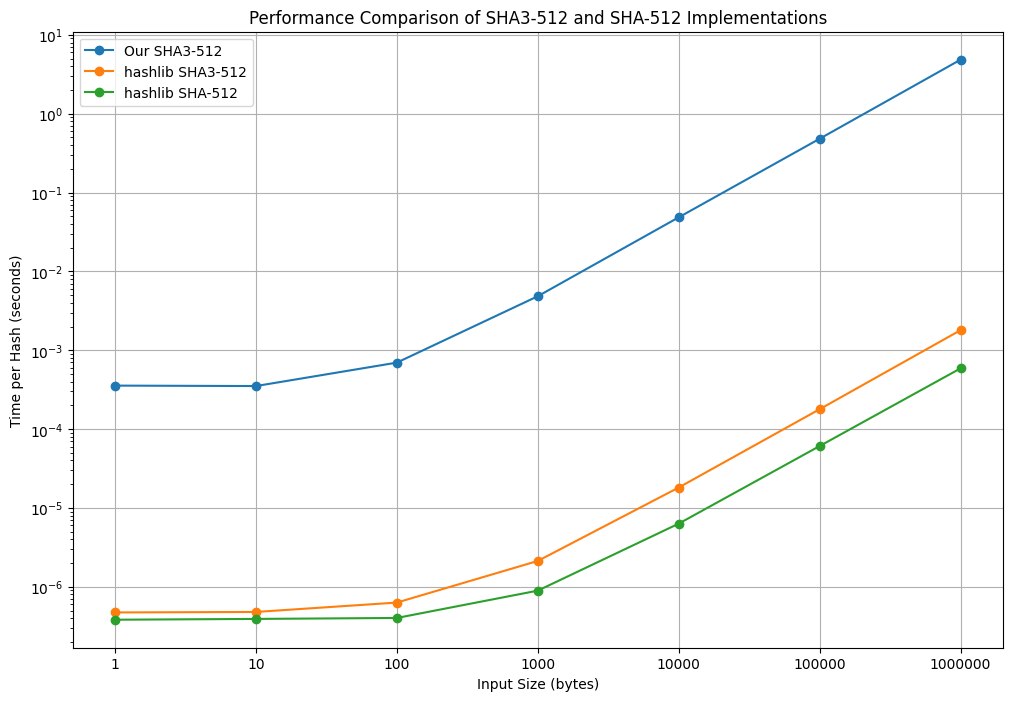

In [25]:
# Plot results
plt.figure(figsize=(12, 8))

# Convert sizes to strings for x-axis labels
size_labels = [str(size) for size in sizes]

# Plot each implementation
plt.plot(size_labels, our_times, 'o-', label='Our SHA3-512')
plt.plot(size_labels, sha3_times, 'o-', label='hashlib SHA3-512')
plt.plot(size_labels, sha2_times, 'o-', label='hashlib SHA-512')

# Set log scale for y-axis
plt.yscale('log')

# Add labels and title
plt.xlabel('Input Size (bytes)')
plt.ylabel('Time per Hash (seconds)')
plt.title('Performance Comparison of SHA3-512 and SHA-512 Implementations')
plt.legend()
plt.grid(True)

# Save the plot
plt.show()

In [26]:
# Print summary
print("\nPerformance Summary:")
print("===================")
print(f"{'Size (bytes)':<15} {'Our SHA3-512 (s)':<20} {'hashlib SHA3-512 (s)':<20} {'hashlib SHA-512 (s)':<20} {'Speedup vs Our':<15}")
print("-" * 90)

for i, size in enumerate(sizes):
    our_time = our_times[i]
    sha3_time = sha3_times[i]
    sha2_time = sha2_times[i]
    
    # Calculate speedup (our implementation vs hashlib)
    sha3_speedup = our_time / sha3_time if sha3_time > 0 else float('inf')
    
    print(f"{size:<15} {our_time:<20.6f} {sha3_time:<20.6f} {sha2_time:<20.6f} {sha3_speedup:.2f}x")


Performance Summary:
Size (bytes)    Our SHA3-512 (s)     hashlib SHA3-512 (s) hashlib SHA-512 (s)  Speedup vs Our 
------------------------------------------------------------------------------------------
1               0.000356             0.000000             0.000000             753.57x
10              0.000351             0.000000             0.000000             733.35x
100             0.000697             0.000001             0.000000             1105.03x
1000            0.004842             0.000002             0.000001             2277.72x
10000           0.048499             0.000018             0.000006             2673.43x
100000          0.481115             0.000179             0.000061             2693.82x
1000000         4.841618             0.001796             0.000589             2695.77x


**Zadanie 6**

Przerób powyższy kod tak, aby stał się funkcją SHA3-256.

In [27]:
# Constants for SHA3-256 (all the remaining code can be reused)
n = 24  # number of rounds
r = 1088 // 8  # rate in bytes (136 bytes)
c = 512 // 8   # capacity in bytes (64 bytes)

def sha3_256(m):
    if isinstance(m, str):
        m = m.encode()
    
    m = pad(m) # We can reuse pad function from sha3_512 implementation
    state = bytearray([0] * 200)
    
    for i in range(0, len(m), r):
        for j in range(r):
            state[j] ^= m[i + j]
        state = compute(state) # we can use compute function from sha3_512 implementation
    
    return bytes(state[:32])

In [28]:
test_strings = [
    "",
    "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa",
    "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"
]

for test_str in test_strings:
    hash_value = sha3_256(test_str)
    print(f"Input: {test_str}")
    print(f"Hash: {hash_value.hex()}")
    print() 

Input: 
Hash: a7ffc6f8bf1ed76651c14756a061d662f580ff4de43b49fa82d80a4b80f8434a

Input: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Hash: faf7e2ca748a48eff17f1f0c6b495ab3f2c3dd34c8d335aee79ceff5fe780a01

Input: aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Hash: 8764aa02abb656c98ecd79c0085479f10126e9aba87d04dbde4fc59778a869fc

